## Convert time series collection of GeoTIFF images to NetCDF

https://gist.github.com/rsignell-usgs/032e8d787da566fc3d666011c514799b

In [1]:
import glob
import pandas as pd
import xarray as xr

We have a collection of remote sensing data over time on the same grid stored in GeoTIFF files. We want to convert them to NetCDF, and rechunk the data with time chunked > 1 so that extraction of time series at specific locations is faster

In [2]:
filenames = glob.glob('/Users/bennyistanto/Downloads/terraclimate/pet/unpack_tif/*.tif')

In [3]:
print(len(filenames))
filenames[0:2]

756


['/Users/bennyistanto/Downloads/terraclimate/pet/unpack_tif/TerraClimate_pet_1998-12-01.tif',
 '/Users/bennyistanto/Downloads/terraclimate/pet/unpack_tif/TerraClimate_pet_1983-01-01.tif']

Make a function to create timestamps from file names

In [4]:
def time_index_from_filenames(filenames):
    '''helper function to create a pandas DatetimeIndex
       Filename example: TerraClimate_pet_1998-12-01.tif'''
    return pd.DatetimeIndex([pd.Timestamp(f.split('/')[-1][17:27].replace('-','')) for f in filenames])

In [5]:
time = xr.Variable('time', time_index_from_filenames(filenames))

Specify reading of all GeoTIFF images. Specifying chunks means that Dask arrays will be used, so no data is read until needed

In [6]:
chunks = {'x': 8640, 'y': 4320, 'band': 1}
da = xr.concat([xr.open_rasterio(f, chunks=chunks).squeeze() for f in filenames], dim=time)

Provide a name for the data array variable

In [7]:
da.name='pet'

Don't need the singleton dimension called 'band', so drop it

In [8]:
da = da.drop(labels='band')

Rechunk the Dask array

In [9]:
da = da.chunk(chunks={'y':100, 'x':100,'time':12})

Let's see what we have now

In [10]:
da

,Array,Chunk
Bytes,210.24 GiB,0.92 MiB
Shape,"(756, 4320, 8640)","(12, 100, 100)"
Count,737856 Tasks,241164 Chunks
Type,float64,numpy.ndarray


Write the NetCDF file, specifying the same chunking. This is where the data finally get read!

In [11]:
encoding={'pet':{'chunksizes': (100,100,12),'zlib': True}}
da.to_netcdf('pet.nc', encoding=encoding, format='NETCDF4', engine='netcdf4', mode='w')

Now open the NetCDF file we just wrote

In [12]:
ds = xr.open_dataset('pet.nc')

In [13]:
ds

<xarray.Dataset>
Dimensions:  (y: 4320, x: 8640, time: 756)
Coordinates:
  * y        (y) float64 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * x        (x) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 179.9 180.0
  * time     (time) datetime64[ns] 1998-12-01 1983-01-01 ... 1993-07-01
Data variables:
    pet      (time, y, x) float64 ...

Extract data at a specific time

In [14]:
dst = ds.sel(time='2019-05-01').squeeze()

Plot it up

/Users/bennyistanto/opt/anaconda3/envs/gis/lib/python3.9/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


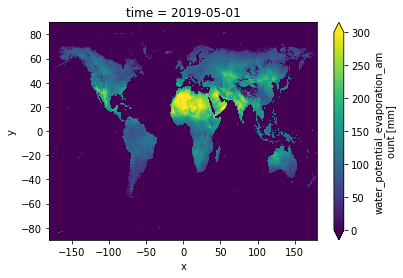

In [15]:
dst['pet'].plot.imshow(vmin=0, vmax=300);